In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import nltk.data
import re, string, unicodedata
import nltk
import matplotlib.pyplot as plt
import time

from unicodedata import normalize
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

arrayHeaders = ["Area", "Dimension", "Respuesta"]
df = pd.read_csv("Data/formattedData.csv", sep=";")

In [2]:
# gs = goslate.Goslate(service_urls=['http://translate.google.es'])

# def verfLengEs(text):
#     if text.isdigit()== False and len(text) > 10:
#         time.sleep(10)
#         leng = gs.detect(text)
#         print(leng)
#         if 'es' == leng:
#             return text
#         else:
#             return ''
#     else:
#         return text
    
#df["Respuesta"][0:100] = df["Respuesta"][0:100].apply(verfLengEs)

In [3]:
dataSentTokenized = df.dropna().copy()
dataSentTokenized["Respuesta"] = dataSentTokenized["Respuesta"].apply(nltk.sent_tokenize)
dataSentTokenized = dataSentTokenized[dataSentTokenized['Respuesta'].map(len) >= 1].copy()
dataSentTokenized = dataSentTokenized.dropna()

In [4]:
arrayExterno = []
def separeSentences(row):
    if type(row['Respuesta']) != str:
        if len(row['Respuesta']) == 1:
            row['Respuesta'] = row['Respuesta'][0]
            return row
        else:
            area = row['Area']
            dimension = row['Dimension']
            for sent in row['Respuesta']:
                tempArray = []
                tempArray.append(area)    
                tempArray.append(dimension)
                tempArray.append(sent)
                arrayExterno.append(tempArray)
            row['Respuesta'] = ""
            return row
    else:
        return row

dataSentTokenized = dataSentTokenized.apply(separeSentences, axis = 1)

In [5]:
dataFrameSentencesSepared = pd.concat([dataSentTokenized,pd.DataFrame(arrayExterno, columns=arrayHeaders)], ignore_index=True) 

In [6]:
def deleteSimbols(tokens):
    return re.sub(r'[^\w\s]', ' ', tokens)
dataFrameSentencesSepared["Respuesta"] = dataFrameSentencesSepared["Respuesta"].apply(deleteSimbols)

In [7]:
dataFrameWordSepared = dataFrameSentencesSepared.copy() 
dataFrameWordSepared["Respuesta"] = dataFrameWordSepared["Respuesta"].apply(nltk.word_tokenize)

In [8]:
largoRespuestas1 = dataFrameWordSepared["Respuesta"].apply(len)
largoRespuestas1.describe()

count    344304.000000
mean          8.152685
std           8.661278
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         306.000000
Name: Respuesta, dtype: float64

In [9]:
stop = stopwords.words('spanish')
def verifyStopWords(tokens):
    for token in tokens:
        if token.lower() in stop:
            tokens.pop(tokens.index(token))
    return tokens

In [10]:
dataTestStop = dataFrameWordSepared.copy()
dataTestStop["Respuesta"] = dataTestStop["Respuesta"].apply(verifyStopWords)

In [11]:
def verifyVoidElements(tokens):
    for token in tokens:
        if token == '' or token == " " or token == "  ":
            tokens.pop(tokens.index(token))
    return tokens

In [12]:
dfMoreWords = dataTestStop.copy()
dfMoreWords["Respuesta"] = dfMoreWords["Respuesta"].apply(verifyVoidElements)
dfMoreWords = dfMoreWords[dfMoreWords['Respuesta'].map(len) > 3].copy()
dfMoreWords = dfMoreWords.dropna()

In [13]:
def normalizeTokens(tokens):
    for token in tokens:
        pos = tokens.index(token)
        if token.isdigit():
            tokens[pos] = ""#num2words(token, lang='es')
        else:
            token = re.sub(r'[^\w\s]', ' ', token)
            if token != ' ' or token != '':
                tokens[pos] = unicodedata.normalize('NFKD', token.lower()).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            else:
                tokens.pop(pos)
    return tokens

In [14]:
dfNormalized = dfMoreWords.copy()
dfNormalized["Respuesta"] = dfNormalized['Respuesta'].apply(normalizeTokens)
dfNormalized["Respuesta"] = dfNormalized['Respuesta'].apply(verifyVoidElements)

In [15]:
DataFinalFlujo1 = dfNormalized.copy()
DataFinalFlujo1["Respuesta"] = DataFinalFlujo1["Respuesta"].apply(verifyStopWords)
DataFinalFlujo1["Respuesta"] = DataFinalFlujo1['Respuesta'].apply(verifyVoidElements)

In [16]:
def verify_spacing_and_numbers(tokens):
    for token in tokens:
        if token.isalpha() == False:
            tokens.pop(tokens.index(token))
    return tokens

DataFinalFlujo1["Respuesta"] = DataFinalFlujo1['Respuesta'].apply(verify_spacing_and_numbers)
DataFinalFlujo1["Respuesta"] = DataFinalFlujo1['Respuesta'].apply(verify_spacing_and_numbers)
DataFinalFlujo1["Respuesta"] = DataFinalFlujo1['Respuesta'].apply(verify_spacing_and_numbers)

In [17]:
def verify_(tokens):
    for token in tokens:
        if token.isalpha() == False:
            print(token,tokens.index(token), len(token))
    return tokens
a = DataFinalFlujo1['Respuesta'].apply(verify_)

In [18]:
DataFinalFlujo1["Respuesta"].apply(len).describe()

count    189038.000000
mean          6.890773
std           4.657309
min           0.000000
25%           4.000000
50%           6.000000
75%           8.000000
max         161.000000
Name: Respuesta, dtype: float64

In [19]:
lemmaDiccionario = {}
with open('Herramientas/lemma.txt', 'rb') as fichero:
    datos = (fichero.read().decode('utf8').replace(u'\r', u'').split(u'\n'))
    datos = ([avance.split(u'\t') for avance in datos])
for avance in datos:
   if len(avance) >1:
      lemmaDiccionario[avance[1]] = avance[0]
        
def lemmatize(word):
   return lemmaDiccionario.get(word, word + u'')
   
def lemmatize_words(words):
    new_words = []
    for palabra in words:
        new_word = lemmatize(palabra)
        new_words.append(new_word)
    return new_words

In [20]:
DataFinalFlujo1["Respuesta"] = DataFinalFlujo1["Respuesta"].apply(lemmatize_words)

In [21]:
largoRespuestas2 = DataFinalFlujo1["Respuesta"].apply(len)
largoRespuestas2.describe()

count    189038.000000
mean          6.890773
std           4.657309
min           0.000000
25%           4.000000
50%           6.000000
75%           8.000000
max         161.000000
Name: Respuesta, dtype: float64

In [22]:
dfMoreWords = DataFinalFlujo1.copy()
dfMoreWords["Respuesta"] = dfMoreWords['Respuesta'].apply(verifyVoidElements)
dfMoreWords = dfMoreWords[dfMoreWords['Respuesta'].map(len) > 3]
#dfMoreWords = dfMoreWords[dfMoreWords['Respuesta'].map(len) <= 15]
dfMoreWords = dfMoreWords.dropna()

In [23]:
def return10first(token):
    if(len(token) > 10):
        return token[0:10]
    else:
        return token
dfMoreWords["Respuesta"] = dfMoreWords["Respuesta"].apply(return10first)

In [24]:
largoRespuestas3 = dfMoreWords['Respuesta'].apply(len)
largoRespuestas3.describe()

count    164889.000000
mean          6.600792
std           2.224210
min           4.000000
25%           5.000000
50%           6.000000
75%           9.000000
max          10.000000
Name: Respuesta, dtype: float64

In [25]:
largoRespuestas3 = dfMoreWords['Respuesta'].apply(len)
largoRespuestas3.describe()

count    164889.000000
mean          6.600792
std           2.224210
min           4.000000
25%           5.000000
50%           6.000000
75%           9.000000
max          10.000000
Name: Respuesta, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x19069b2b518>,
 'caps': [<matplotlib.lines.Line2D at 0x19069b2a860>,
 'boxes': [<matplotlib.lines.Line2D at 0x19069b33e10>],
 'medians': [<matplotlib.lines.Line2D at 0x19069b260b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x19069b26908>],
 'means': []}

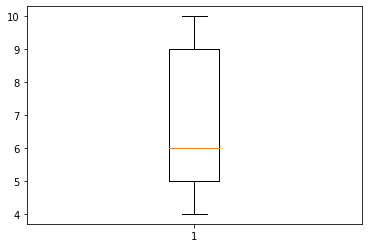

In [26]:
plt.subplots()
dataToPlot = [largoRespuestas3]
plt.boxplot(dataToPlot)

#Fin Flujo 1

In [28]:
max_quantity = 0
for name, group in dfMoreWords.groupby(['Area','Dimension']):
    if len(group)>max_quantity:
        max_quantity = len(group)

In [29]:
array_groups_to_remove = []
for name, group in dfMoreWords.groupby(['Area','Dimension']):
    if len(group) <= max_quantity/10:
        array_groups_to_remove.append(name)

In [30]:
def remove_categories_(row):
    if((row['Area'], row['Dimension']) in array_groups_to_remove):
        return 
    else:
        return row
    
dfMoreWords = dfMoreWords.apply(remove_categories_, axis = 1)


In [31]:
dfMoreWords.groupby(['Area','Dimension']).count().Respuesta

Area                  Dimension                   
Confianza General     Confianza General               11871
Gobierno Corporativo  Anti-corrupción                  7067
                      Integridad                       7231
Medio Ambiente        Ambiental                        2128
                      Cultura Ambiental               10840
Social Externo        Calidad                          6722
                      Cliente                          5801
                      Comunicación                     3097
                      Comunidad                        4957
                      Educación                        1895
                      Imagen                           6362
                      Infraestructura                  1994
                      Operación                        2085
                      Proveedores                      2088
                      Reclamos                         5914
                      Recompra                   

In [37]:
dfMoreWords = dfMoreWords.dropna()

In [41]:
dfMoreWords.to_csv("Data/Flujo1.csv", sep=";", index=False)